# SIR model with testing
Notebook accompanying this [blog post](https://chris-said.io/2020/07/15/why-inaccurate-antigen-tests-are-better-than-slow-pcr-tests/).

The model is inspired by the example from [this book](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/) by Christian Hill, but heavily modified.
Modifications are:
* Is agent-based rather than rate-based
* Includes testing, with fixed delays between infection and detectability and between test and results.
* Includes a quarantine state, of fixed duration.
* Includes infections that can arrive from outside the population.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
blue = np.array([58., 195., 242.]) / 255
pink = np.array([237., 38., 133.]) / 255
orange = np.array([245, 128, 50]) / 255
yellow = np.array([241, 211, 33]) / 255
gray = np.array([150, 150, 150]) / 255
red = np.array([237, 18, 98]) / 255
green = np.array([18, 237, 157]) / 255

In [3]:
figure_path = '/Users/chrissaid/Dropbox/Blog/csaid.github.io/assets/2020_antigen_testing'


### Plotting functions

In [4]:
def plot_raster(df, state_logs):
    state_logs = state_logs.replace('S', 0).replace('I', 1).replace('Q', 2).replace('R', 3)
    state_logs = state_logs.loc[df.sort_values('infection_date').index,:]
    plt.figure(figsize=[20,7])
    sns.heatmap(state_logs, cmap=[green, red, gray, 'w'], cbar=False)
    plt.yticks([]);
    plt.xlabel('Date');

def plot_sir(results, include_Q=False):
    plt.plot(results['S'], label='S')
    plt.plot(results['I'], label='I')
    plt.plot(results['R'], label='R')
    if include_Q:
        plt.plot(results['Q'], label='Q')
        
    sns.despine()
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend()

def get_candidate_name_from_config(config):
    return f"Interval={config['testing_interval']}; Delay={config['testing_delay']}; Sensitivity={config['sensitivity']}"

def preplot():
    plt.figure(figsize=[10, 5])
    plt.plot(results_worst_case['cumulative_infections'], color='k', alpha=0.8, label='No testing')

def postplot():
    plt.plot(results_best_case['cumulative_infections'], color='k', alpha=0.4, label='No intra-school infection')
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Cumulative infections', fontsize=14)
    sns.despine()
    plt.legend();

### Simulation functions

In [5]:
def run_simulation(testing_interval=5,
                   testing_delay=3,
                   infection_to_detectable_delay=0,
                   beta=0.2, 
                   gamma=0.07, 
                   Q_duration=14,
                   I_initial=5,
                   N=200,
                   num_days=130,
                   sensitivity=0.8,
                   external_infection_rate=0.001,
                  ):
    """
    testing_interval: 
        The number of days between each test. Students are put on a rotation, so that if testing_interval=5,
        then 1/5 of the students would get tested on the first day, 1/5 on the second day, and so on.
    testing_delay:
        The number of days between test and results
    infection_to_detectable_delay:
        The number of days between infection and when it would be detectable in a test.
    beta:
        The number of contacts per person that would result in an infection (if one was S and the other I)
    gamma:
        Recovery rate.
    Q_duration:
        Quarantine duration
    I_initial:
        Number of students already infected on day 1.
    N:
        Number of students
    num_days:
        Number of days to simulate
    sensitivity:
        The sensitivity (aka recall) of the test (true positives / num_infected)
    external_infection_rate: 
        The probability on any given day that someone comes in infection-causiongcontact with an infected person outside the school.
    """
    
    df = pd.DataFrame({
        'state': 'S',
        'positive_test_dates': [set() for _ in range(N)],
        'quarantine_start_date': np.nan,
        'infection_date': np.nan,
        'days_in_I': 0,
    })
    initial_infections = np.random.choice(df.index, I_initial, replace=False)
    df.loc[initial_infections, 'state'] = 'I'
    df.loc[initial_infections, 'infection_date'] = 0    
    state_logs = []
    state_counts = {}
    for date in range(num_days):

        # For logging
        state_logs += [df['state'].rename(date)]
        
        state_counts[date] = df['state'].value_counts().to_dict()
        S = state_counts[date].get('S', 0)
        I = state_counts[date].get('I', 0)
        R = state_counts[date].get('R', 0)
        Q = state_counts[date].get('Q', 0)
        
        if testing_interval is not None:
            
            # Release anyone who has finished quarantine
            to_release = date - df['quarantine_start_date'] == Q_duration
            df.loc[to_release, 'state'] = 'R' # Assume recovery by release from quarantine
            
            # Run tests on everyone assigned to test on that date.
            will_be_detected = (((df.index + date) % testing_interval == 0) &
                                (df['state'] == 'I') & 
                                (np.random.rand(N) < sensitivity) &
                                (date - df['infection_date'] >= infection_to_detectable_delay))
            df.loc[will_be_detected, 'positive_test_dates'] = df.loc[will_be_detected, 'positive_test_dates'].apply(lambda s: s.union({date}))
            
            # Receive earlier test results and put new positives in quarantine.
            is_detected = (df['state'] != 'Q') & df['positive_test_dates'].apply(lambda test_dates: date - testing_delay in test_dates) 
            df.loc[is_detected, 'state'] = 'Q'
            df.loc[is_detected, 'quarantine_start_date'] = date
            

        # Infected -> Recovered transition
        df.loc[((df['state'] == 'I') & (np.random.rand(N) < gamma)), 'state'] = 'R'
        
        
        # Susceptible -> Infected transition
        # Easiest to think of beta as the number of contact a potential recipient person makes. 
        # The probability that all of those contacts are with safe people is (((N-Q)-I)/(N-Q))**beta
        df['has_contact_with_internal_infected'] = np.random.rand(N) < 1 - (((N-Q)-I)/(N-Q))**beta
        df['has_contact_with_external_infected'] = np.random.rand(N) < external_infection_rate
        is_susceptible = df['state'] == 'S'
        has_contact = df['has_contact_with_internal_infected'] | df['has_contact_with_external_infected']
        df.loc[is_susceptible & has_contact, 'state'] = 'I'
        df.loc[is_susceptible & has_contact, 'infection_date'] = date
        
        # Logging
        df.loc[(df['state'] == 'I'), 'days_in_I'] = df.loc[(df['state'] == 'I'), 'days_in_I'] + 1
                
        cumulative_infections = df['infection_date'].value_counts().sort_index().cumsum().reindex(range(num_days), method='pad')

    return pd.DataFrame(state_counts).T.fillna(0), cumulative_infections, df, pd.concat(state_logs, axis=1)


In [6]:
def run_simulations(config, niter=25):
    all_state_counts = []
    all_cumulative_infections = []
    for i in range(niter):
        state_counts, cumulative_infections, _, _ = run_simulation(**config)
        all_state_counts.append(state_counts)
        all_cumulative_infections.append(cumulative_infections)
    results = {
        'state_counts': pd.concat(all_state_counts).groupby(level=0).mean(),
        'cumulative_infections': pd.concat(all_cumulative_infections).groupby(level=0).mean(),
    }
    return results
        

## Sanity checks 

### Replicating results in [book](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

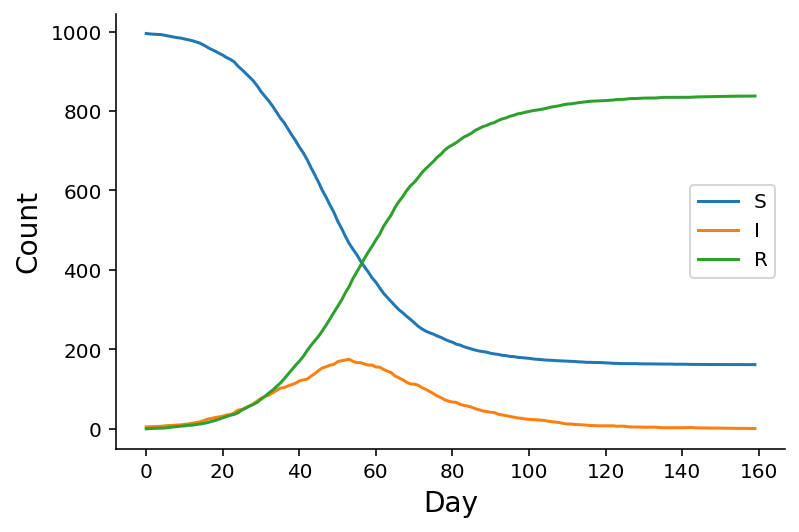

In [7]:
config = { 
    'beta': 0.2,
    'gamma': 0.1,
    'testing_interval': None, 
    'external_infection_rate': 0, 
    'N': 1000,
    'num_days': 160,
}
results = run_simulations(config, niter=5)
plot_sir(results['state_counts'])

### Rasters
* Each row is an individual. 
* Rows are sorted by infection onset date.
* Susceptible is green, Infected is red, Quarantined is gray, Recovered is white.

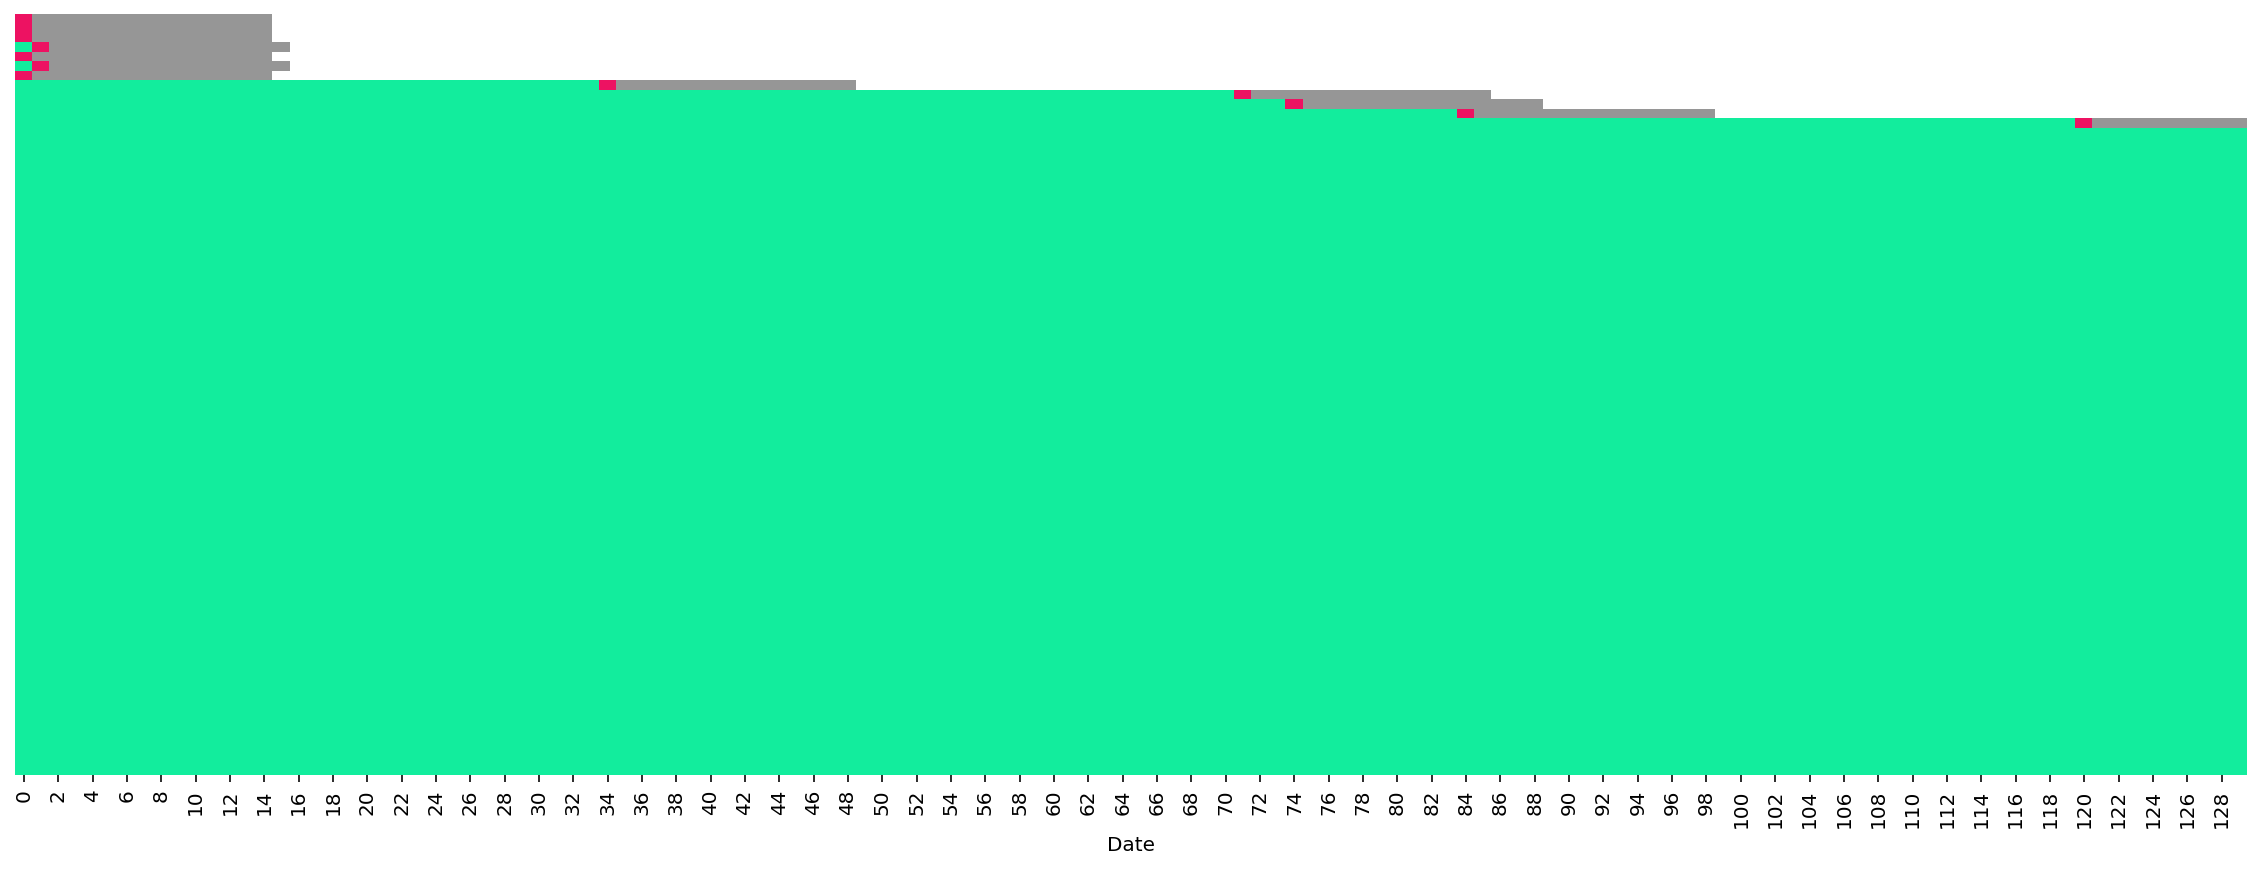

In [8]:
# Ideal conditions with perfect, rapid tests. Here we expect all infections to last exactly one day
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=1, 
    testing_delay=0,
    sensitivity=1.0,
    infection_to_detectable_delay=0,
)
plot_raster(df, state_logs)

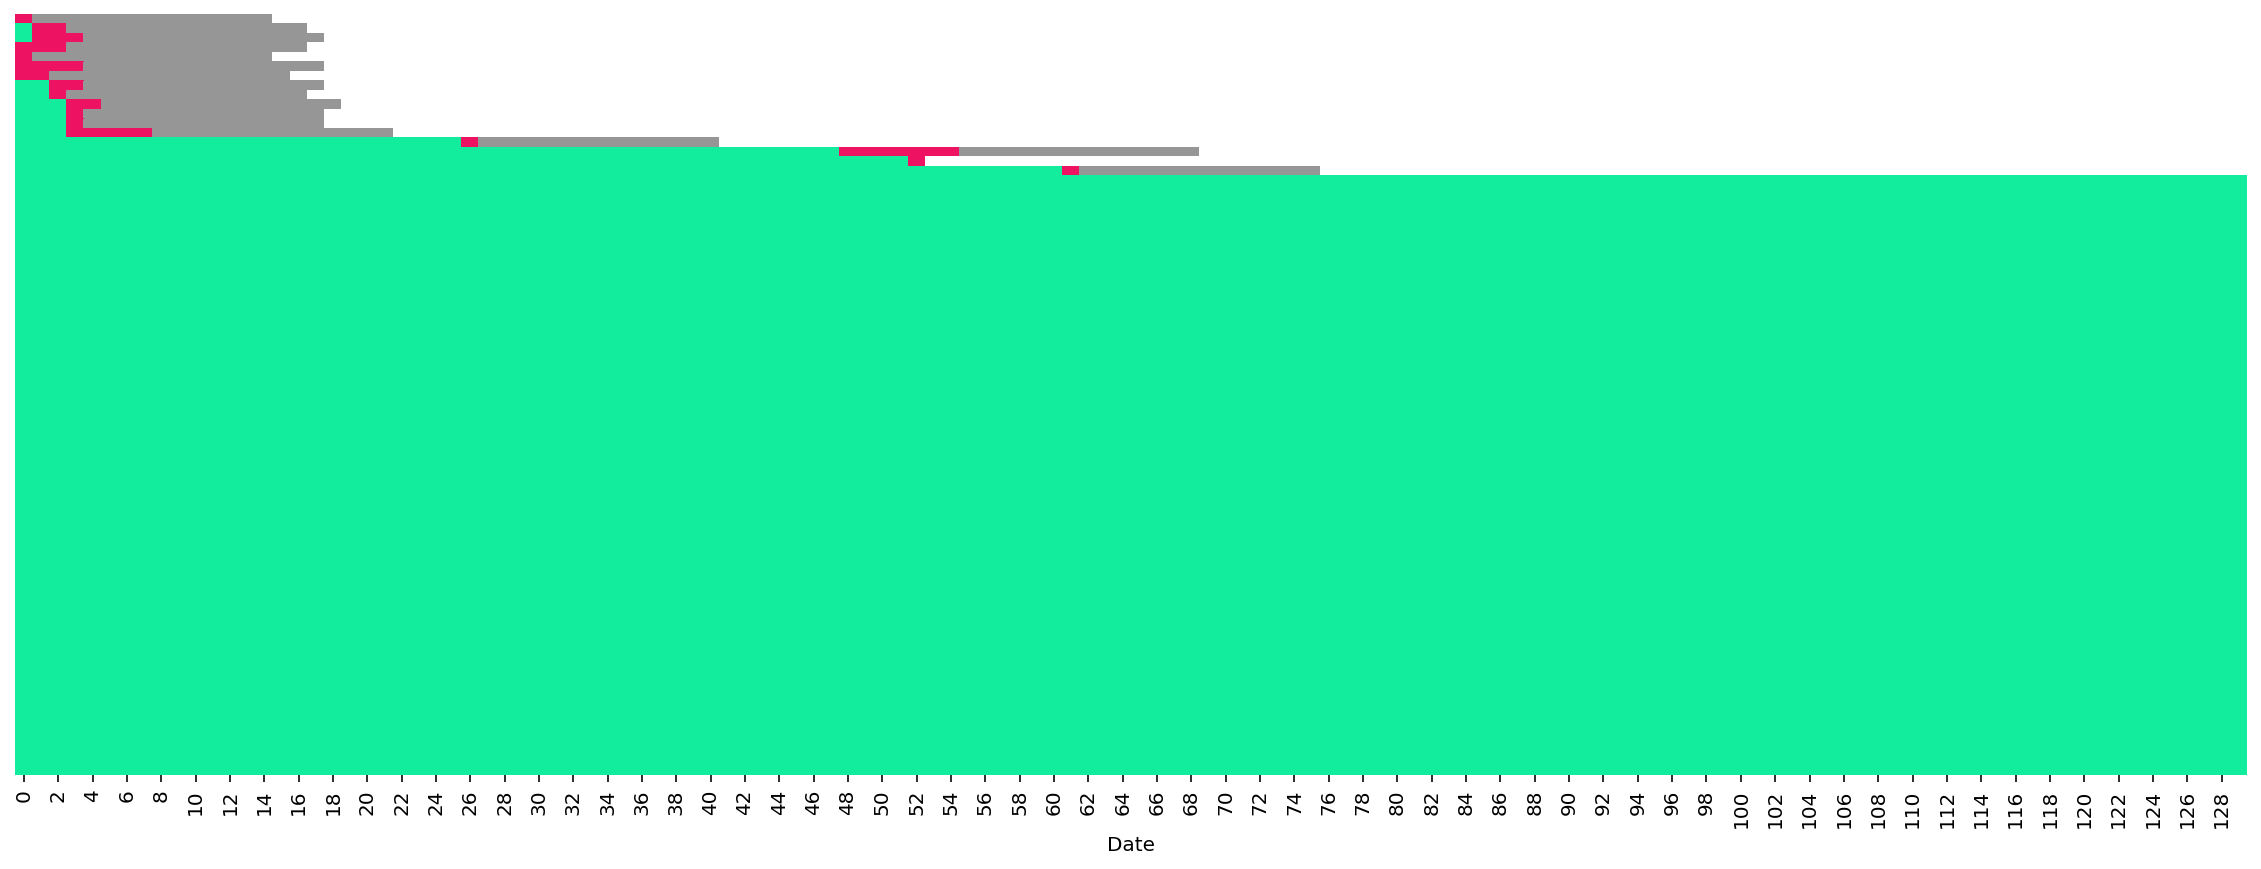

In [9]:
# Here the only weakness is reduced sensitivity. We expect quarantines to be delayed by a variable amount.
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=1, 
    testing_delay=0,
    sensitivity=.5,
    infection_to_detectable_delay=0,
)
plot_raster(df, state_logs)

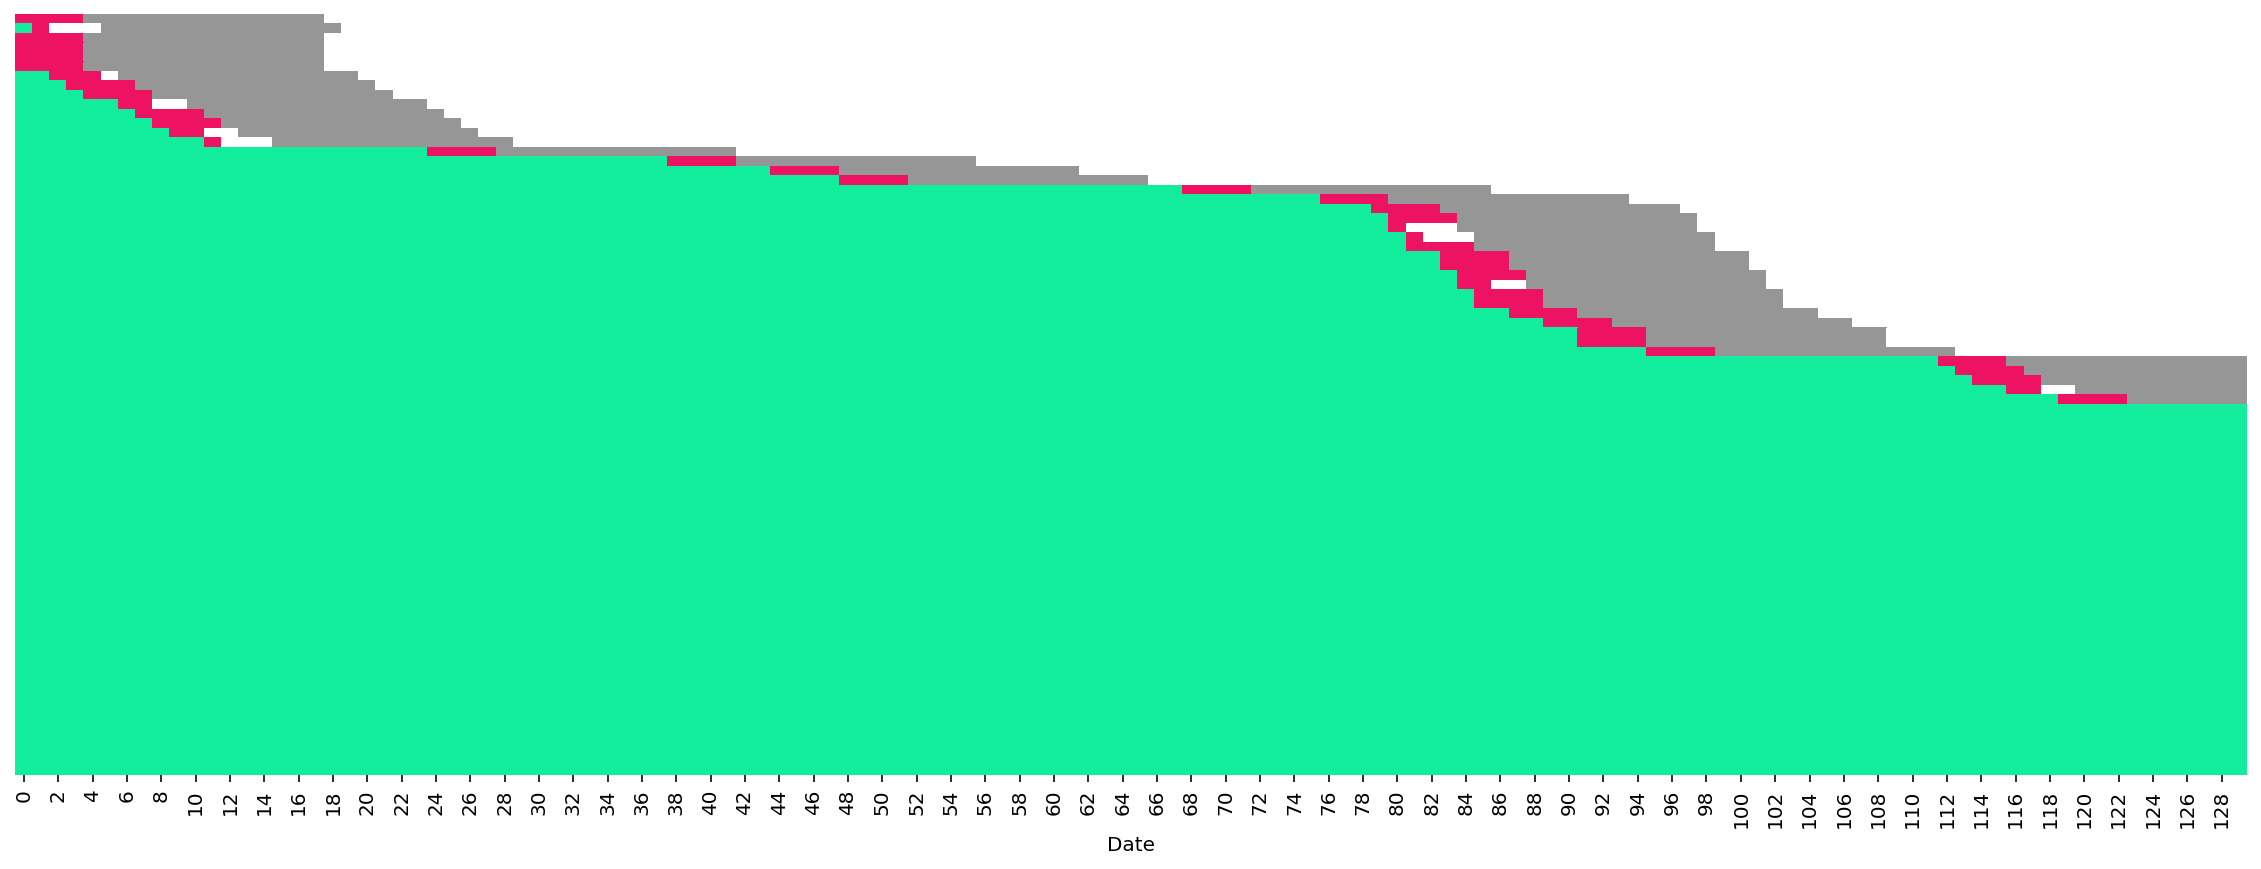

In [10]:
# Here the only weakness is testing delay. We expect all quarantines to be delayed by the same amount.
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=1, 
    testing_delay=3,
    sensitivity=1,
    infection_to_detectable_delay=0,
)
plot_raster(df, state_logs)

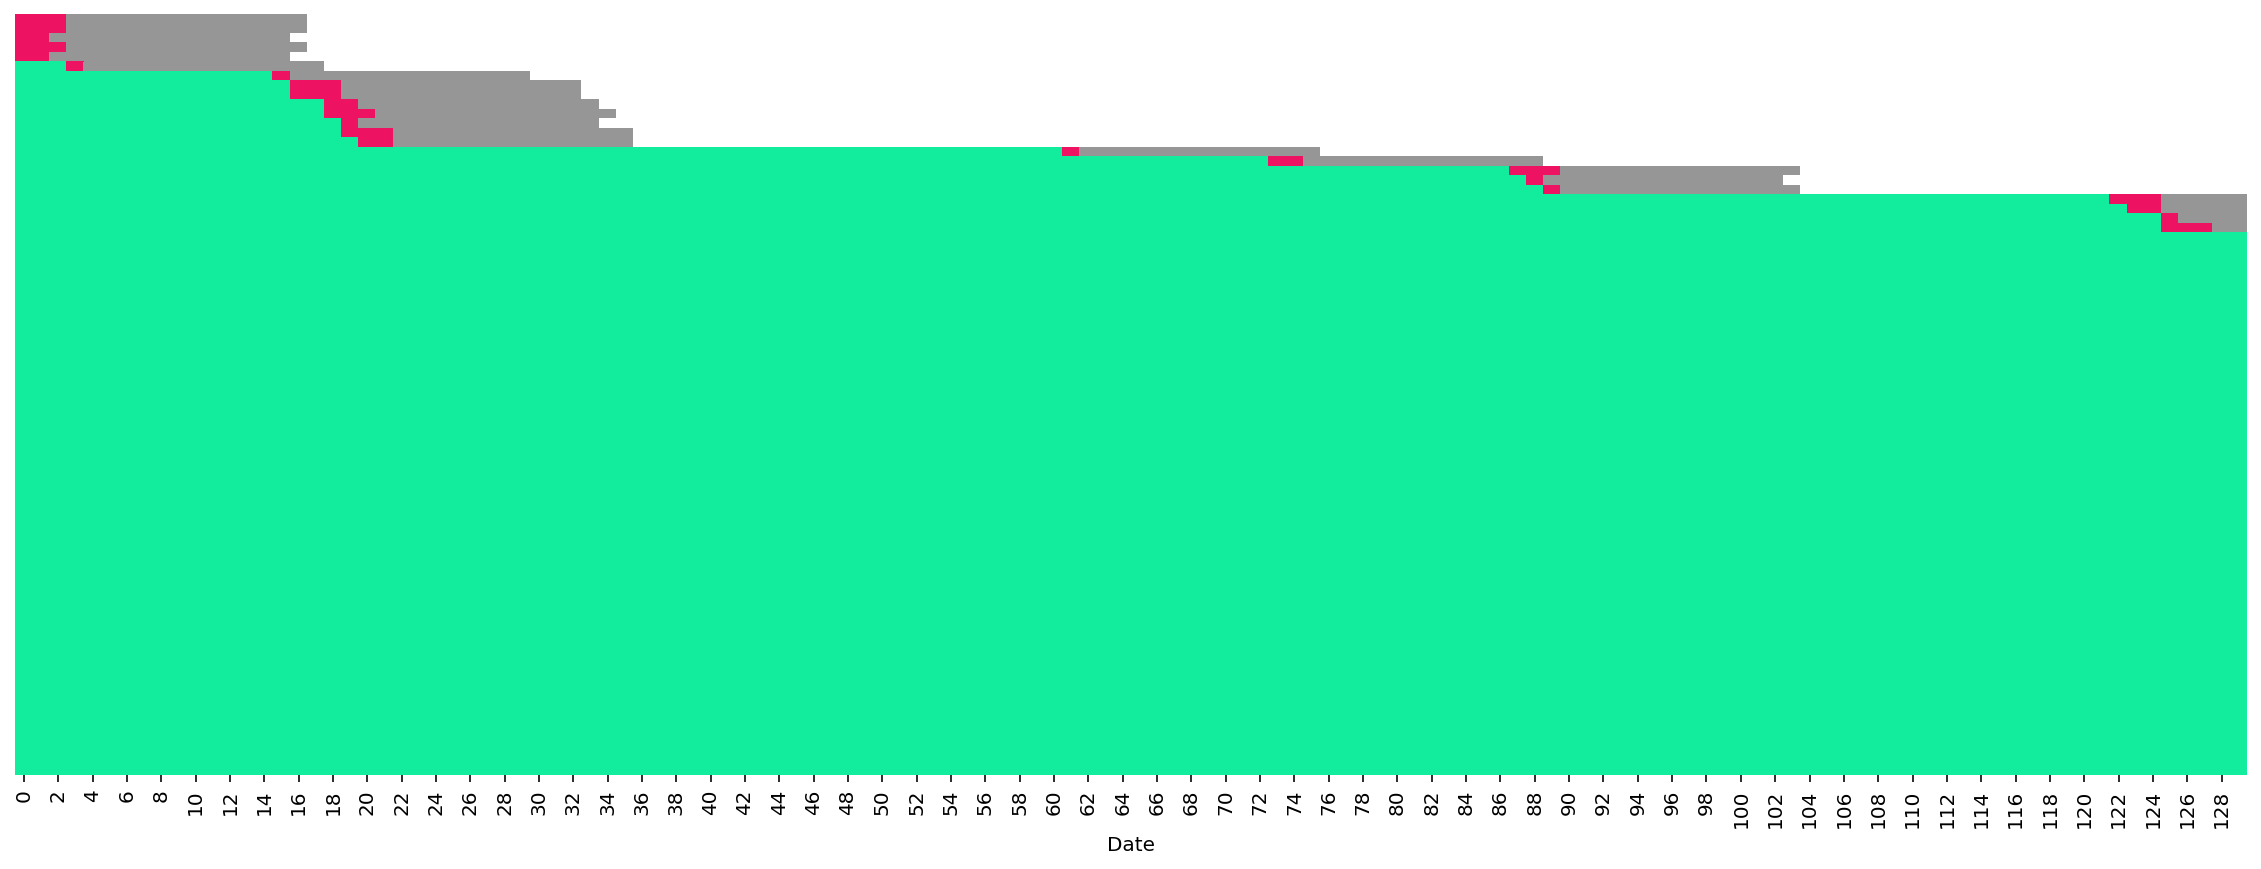

In [11]:
# Here the only weakness is testing interval. We expect quarantines to be delayed by a variable amount.
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=3, 
    testing_delay=0,
    sensitivity=1,
    infection_to_detectable_delay=0,
)
plot_raster(df, state_logs)

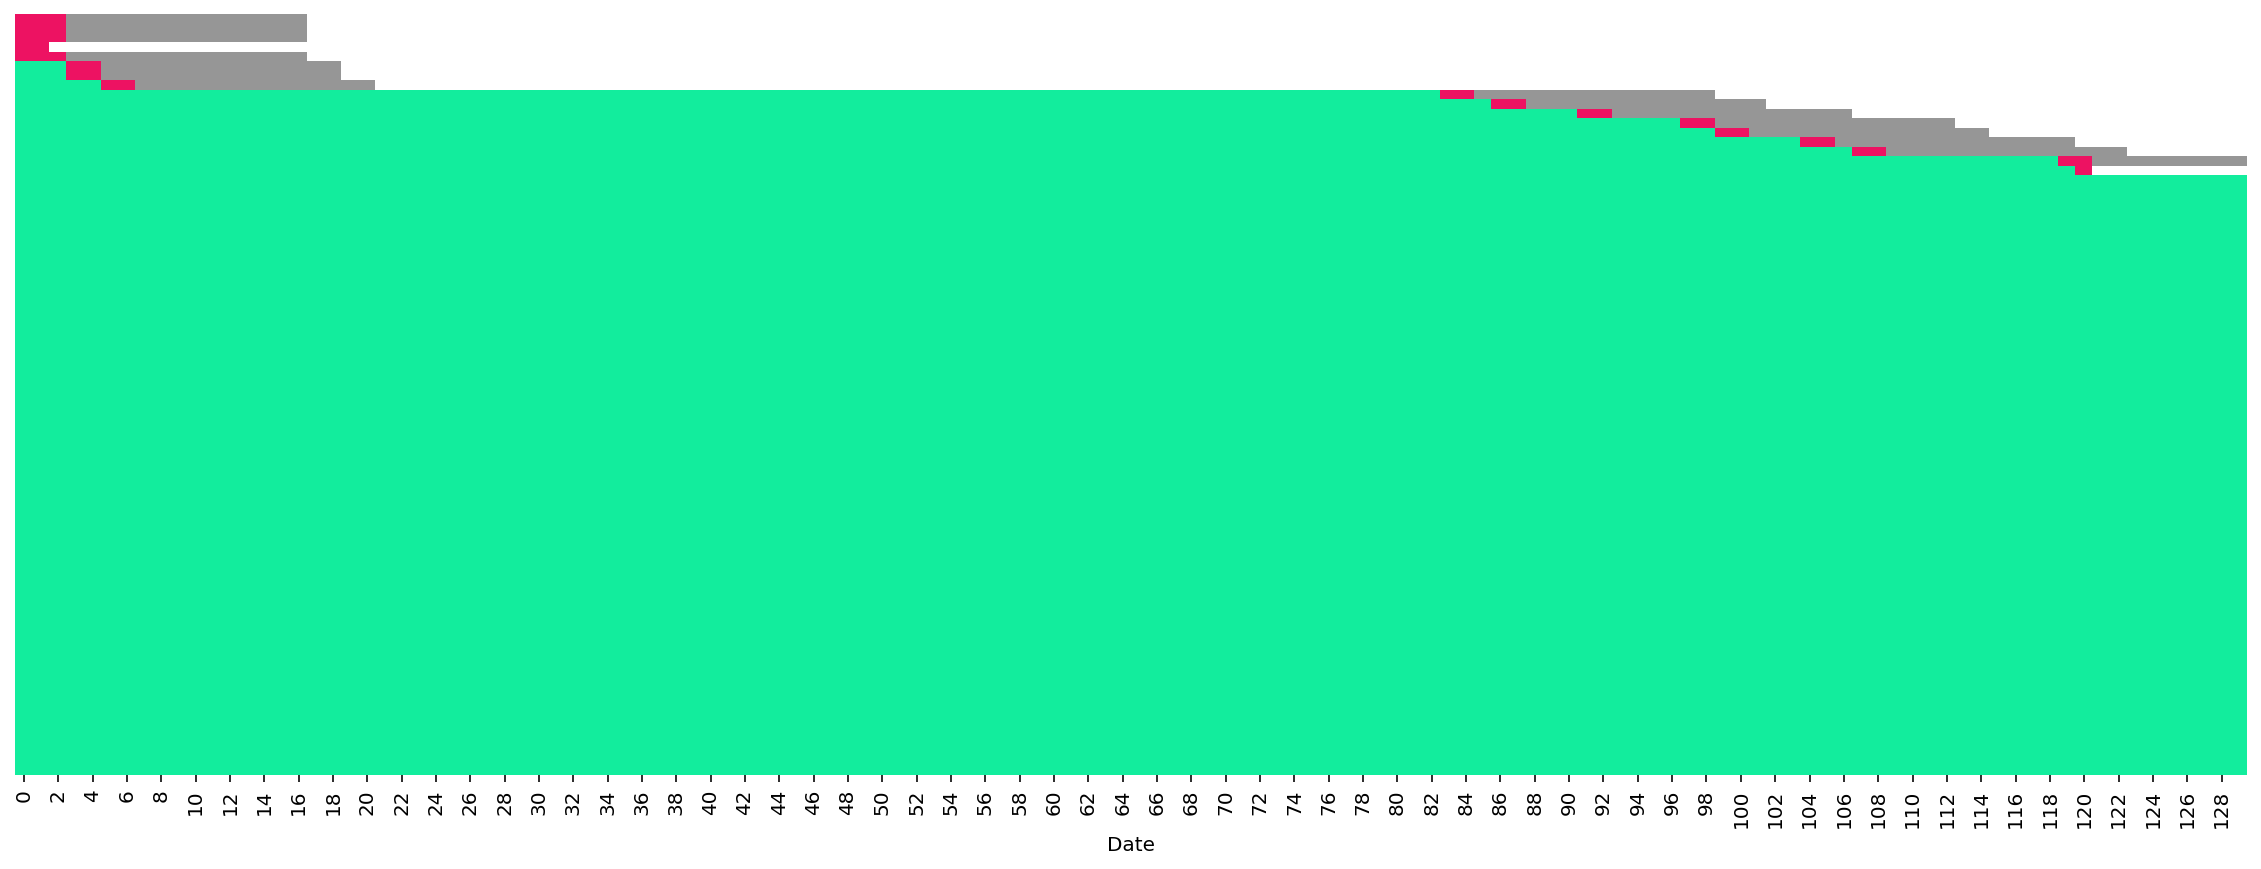

In [12]:
# Here the only weakness is an infection_to_detectable_delay. We expect all quarantines to be delayed by the same amount.
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=1, 
    testing_delay=0,
    sensitivity=1,
    infection_to_detectable_delay=2,
)
plot_raster(df, state_logs)

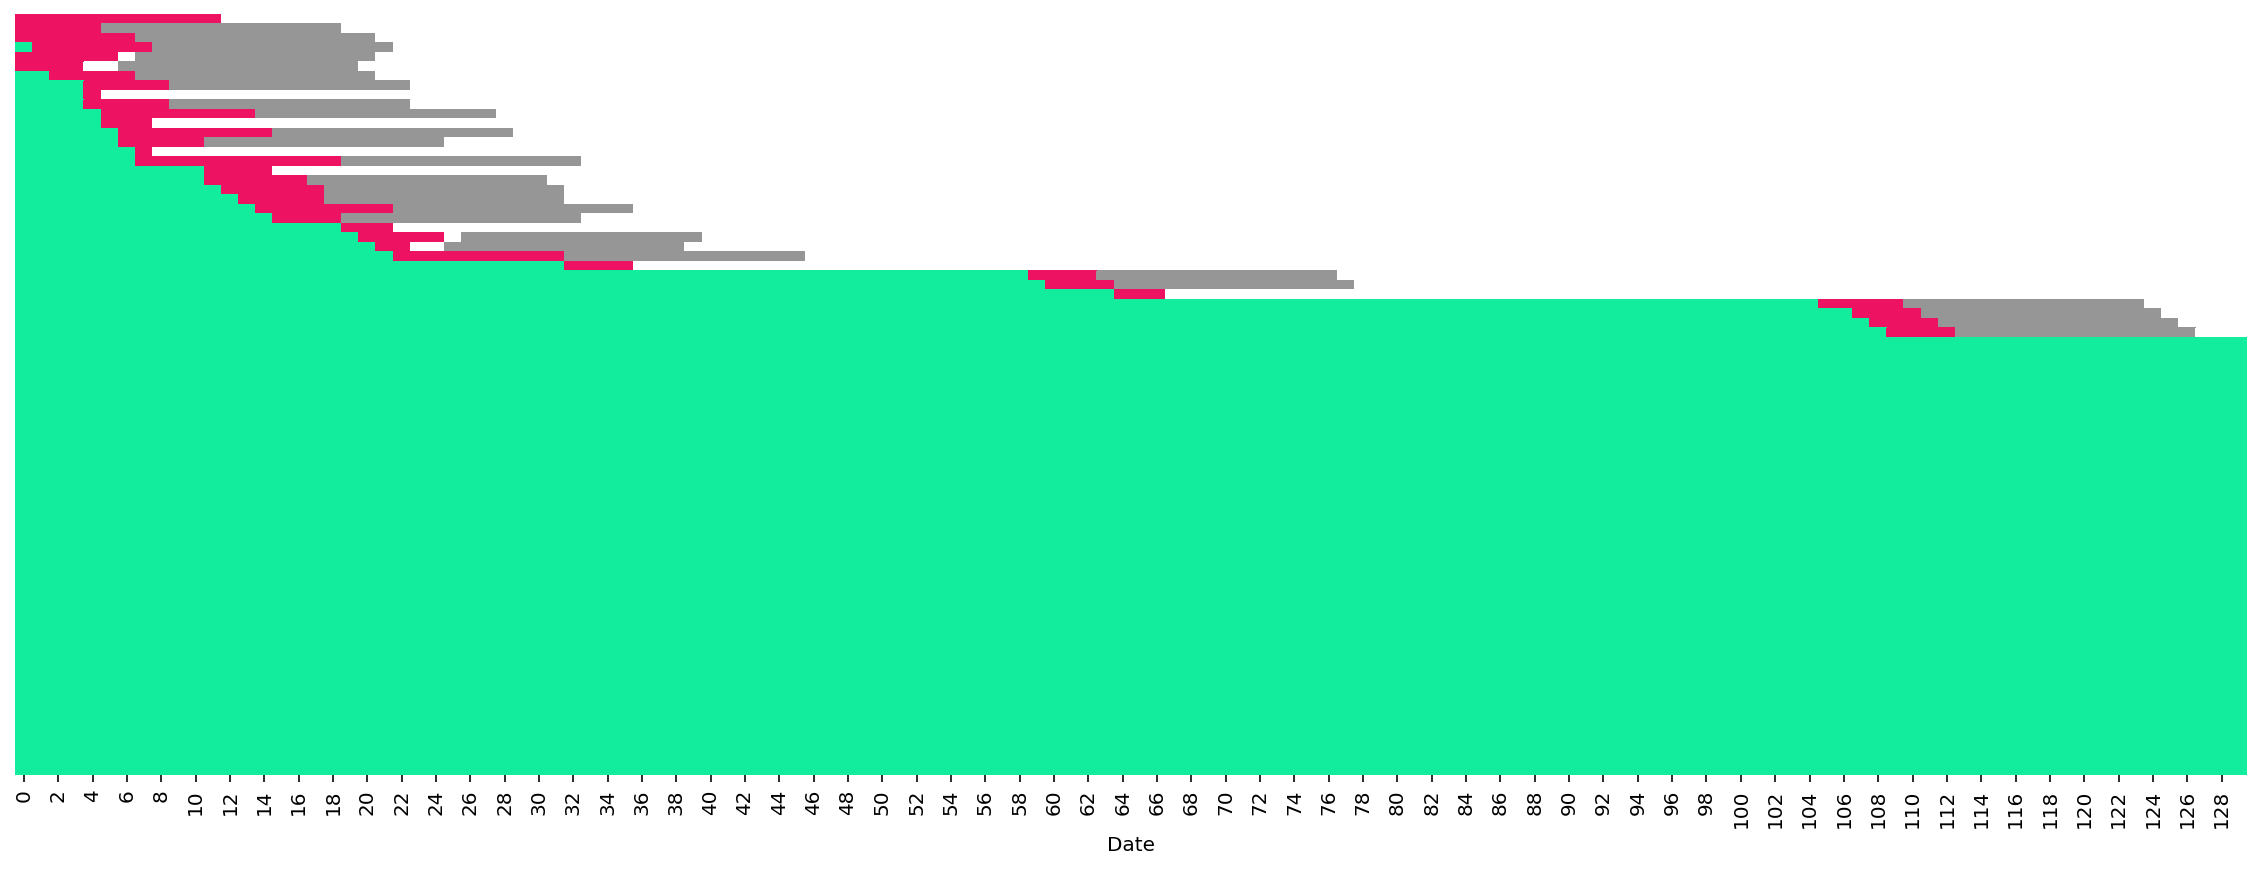

In [13]:
# Here we combine multiple weaknesses. We expect quarantines to be delayed by a variable amount.
state_counts, cumulative_infections, df, state_logs = run_simulation(
    N=80,
    testing_interval=3, 
    testing_delay=2,
    sensitivity=0.8,
    infection_to_detectable_delay=2,
)
plot_raster(df, state_logs)

## Best and worst case scenario

In [14]:
results_worst_case = run_simulations({'testing_interval': None})
results_best_case = run_simulations({'beta': 0}) # No intra-school infections

## PCR vs Antigen

In [15]:
config={
    'testing_interval': 4, 
    'testing_delay': 5,
    'sensitivity': 0.98
}
candidate_name_4_5_98 = 'PCR every 4 days'
results_4_5_98 = run_simulations(config)

config={
    'testing_interval': 4, 
    'testing_delay': 0,
    'sensitivity': 0.75
}
candidate_name_4_0_75 = 'Antigen every 4 days'
results_4_0_75 = run_simulations(config)

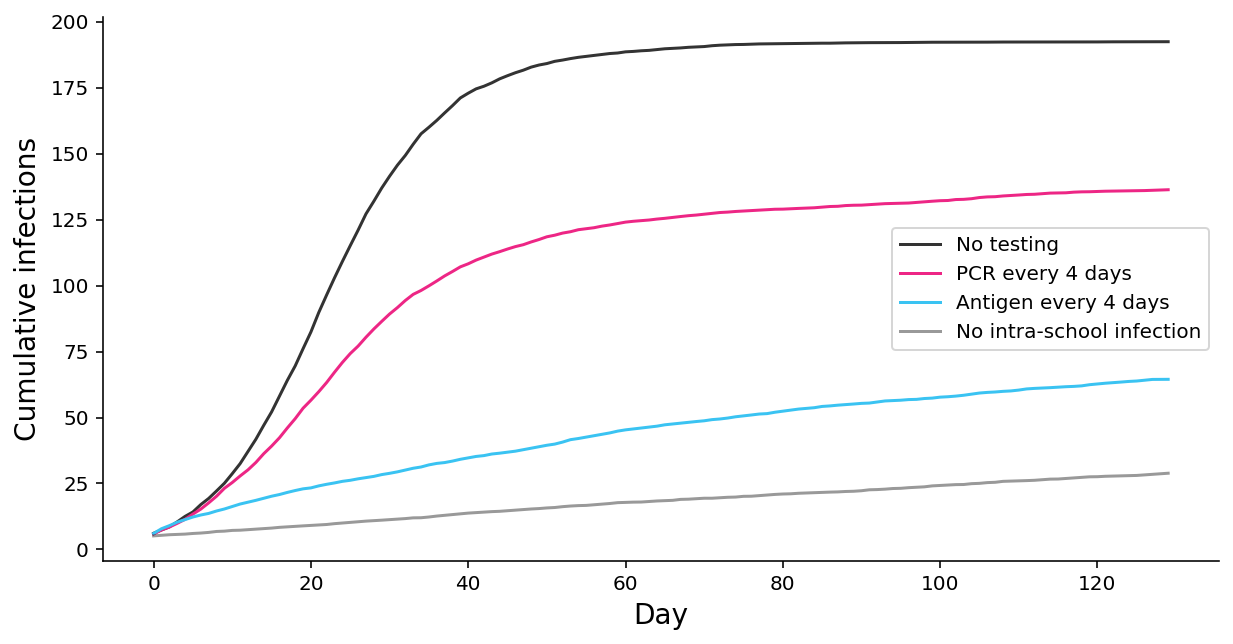

In [16]:
preplot()
plt.plot(results_4_5_98['cumulative_infections'], color=pink, alpha=1.0, label=candidate_name_4_5_98)
plt.plot(results_4_0_75['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_4_0_75)
postplot()
plt.savefig(f'{figure_path}/fig_test_every_4_days.png', dpi=150)


In [13]:
config={
    'testing_interval': 1, 
    'testing_delay': 5,
    'sensitivity': 0.98
}
candidate_name_1_5_98 = 'PCR every day'
results_1_5_98 = run_simulations(config)

config={
    'testing_interval': 1, 
    'testing_delay': 0,
    'sensitivity': 0.75
}
candidate_name_1_0_75 = 'Antigen every day'
results_1_0_75 = run_simulations(config)

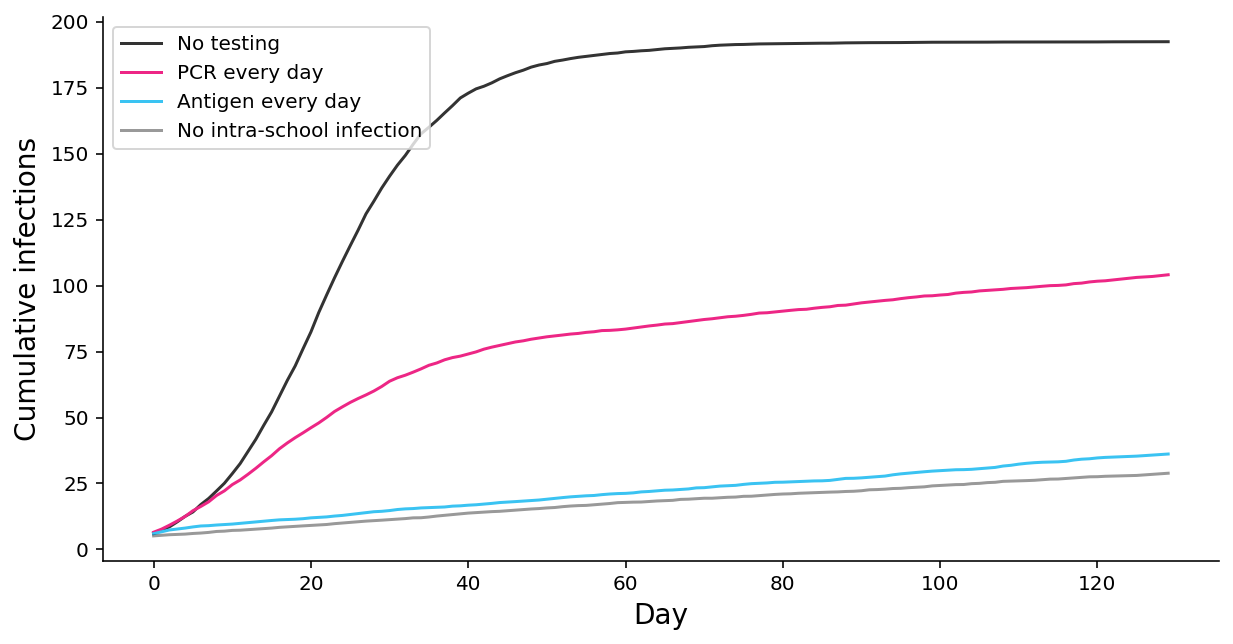

In [14]:
preplot()
plt.plot(results_1_5_98['cumulative_infections'], color=pink, alpha=1.0, label=candidate_name_1_5_98)
plt.plot(results_1_0_75['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_1_0_75)
postplot()
plt.savefig(f'{figure_path}/fig_test_every_1_day.png', dpi=150)


In [15]:
config={
    'testing_interval': 1, 
    'testing_delay': 5,
    'sensitivity': 0.98,
    'infection_to_detectable_delay': 0,
}
candidate_name_1_5_98_0 = 'PCR every day'
results_1_5_98_0 = run_simulations(config)

config={
    'testing_interval': 1, 
    'testing_delay': 0,
    'sensitivity': 0.75,
    'infection_to_detectable_delay': 2,
}
candidate_name_1_0_75_2 = 'Antigen every day (Ineffective for first 2 days)'
results_1_0_75_2 = run_simulations(config)

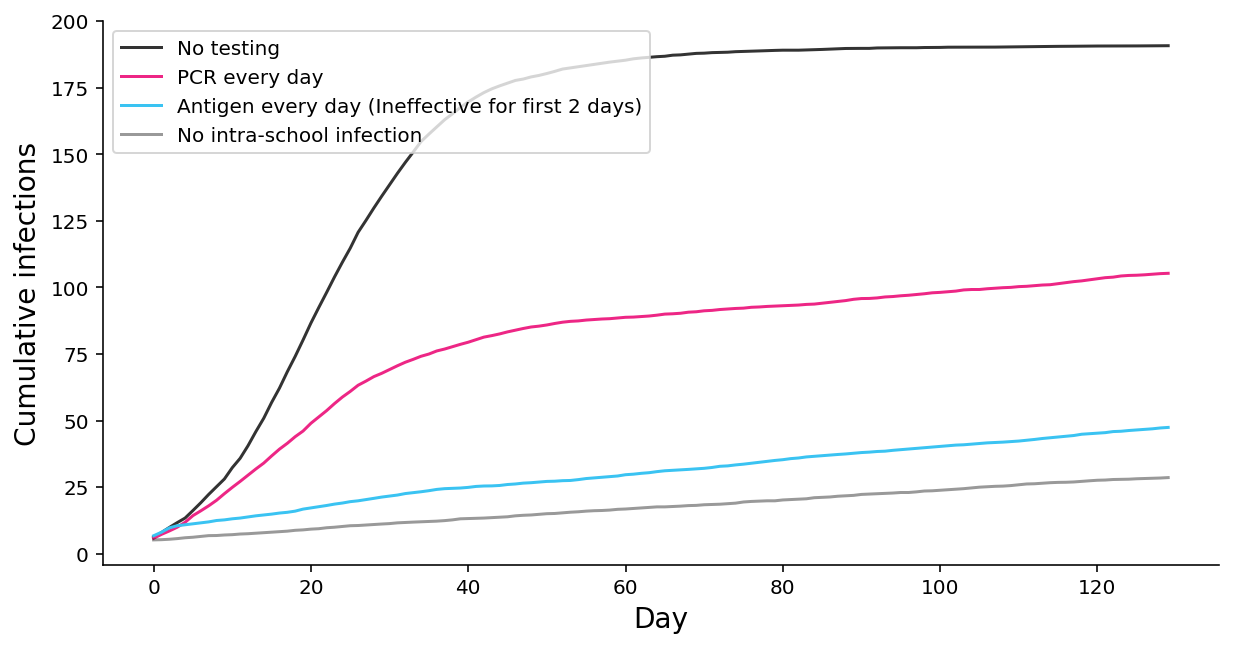

In [16]:
preplot()
plt.plot(results_1_5_98_0['cumulative_infections'], color=pink, alpha=1.0, label=candidate_name_1_5_98_0)
plt.plot(results_1_0_75_2['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_1_0_75_2)
postplot()
plt.savefig(f'{figure_path}/fig_test_every_1_day_delayed_detection.png', dpi=150)


### Relation between sensitivity and testing delay

In [51]:
def get_effective_delay(sensitivity):
    # Assumes daily tests
    fn = 1-sensitivity
    dates = np.arange(0, 20)
    prob_detect_by_date = fn**(dates)*sensitivity
    return ((dates) * prob_detect_by_date).sum()

print('Effective delay (in days) for daily tests if sensitivity is 50%:', get_effective_delay(0.50))
print('Effective delay (in days) for daily tests if sensitivity is 75%:', get_effective_delay(0.75))


Effective delay (in days) for daily tests if sensitivity is 50%: 0.9999799728393555
Effective delay (in days) for daily tests if sensitivity is 75%: 0.3333333333148403


In [52]:
config={
    'testing_interval': 1, 
    'testing_delay': 1,
    'sensitivity': 1.0,
}
candidate_name_1_1_100 = get_candidate_name_from_config(config)
results_1_1_100 = run_simulations(config)

config={
    'testing_interval': 1, 
    'testing_delay': 0,
    'sensitivity': 0.5,
}
candidate_name_1_0_50 = get_candidate_name_from_config(config)
results_1_0_50 = run_simulations(config)

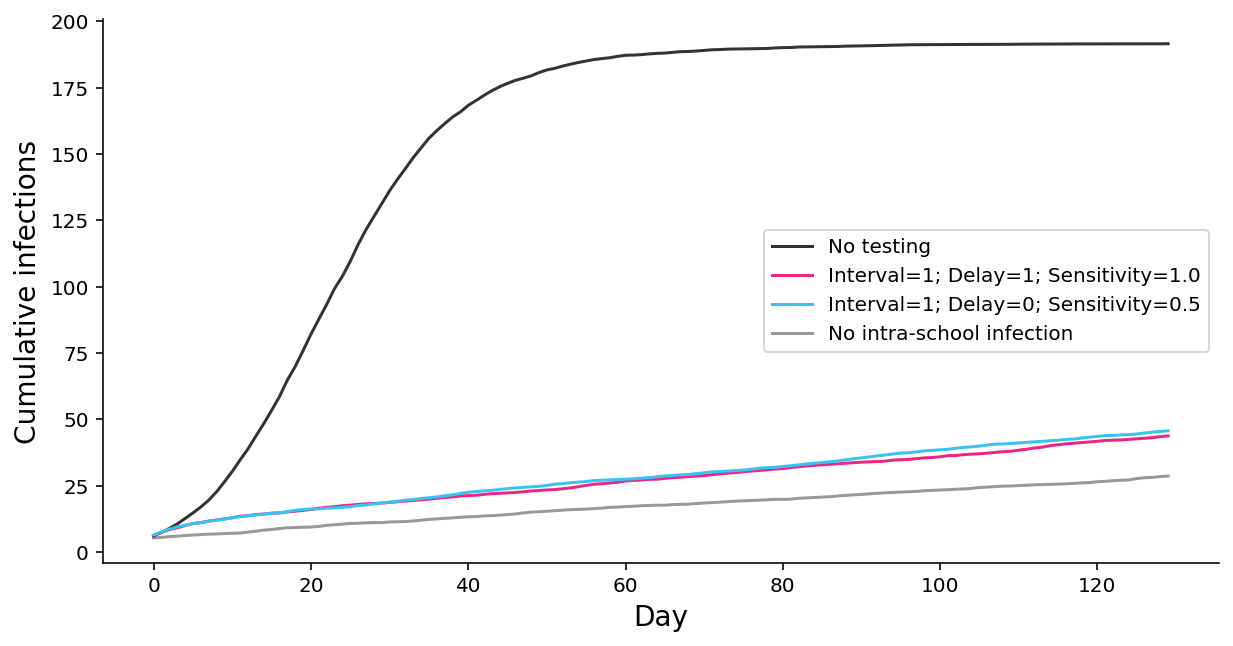

In [53]:
preplot()
plt.plot(results_1_1_100['cumulative_infections'], color=pink, alpha=1.0, label=candidate_name_1_1_100)
plt.plot(results_1_0_50['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_1_0_50)
postplot()

## Parameter sweeps

In [54]:
config={
    'testing_interval': 5, 
    'testing_delay': 0,
    'sensitivity': 0.75
}
candidate_name_5_0_75 = get_candidate_name_from_config(config)
results_5_0_75 = run_simulations(config)

config={
    'testing_interval': 3, 
    'testing_delay': 0,
    'sensitivity': 0.75
}
candidate_name_3_0_75 = get_candidate_name_from_config(config)
results_3_0_75 = run_simulations(config)

config={
    'testing_interval': 1, 
    'testing_delay': 0,
    'sensitivity': 0.75
}
candidate_name_1_0_75 = get_candidate_name_from_config(config)
results_1_0_75 = run_simulations(config)

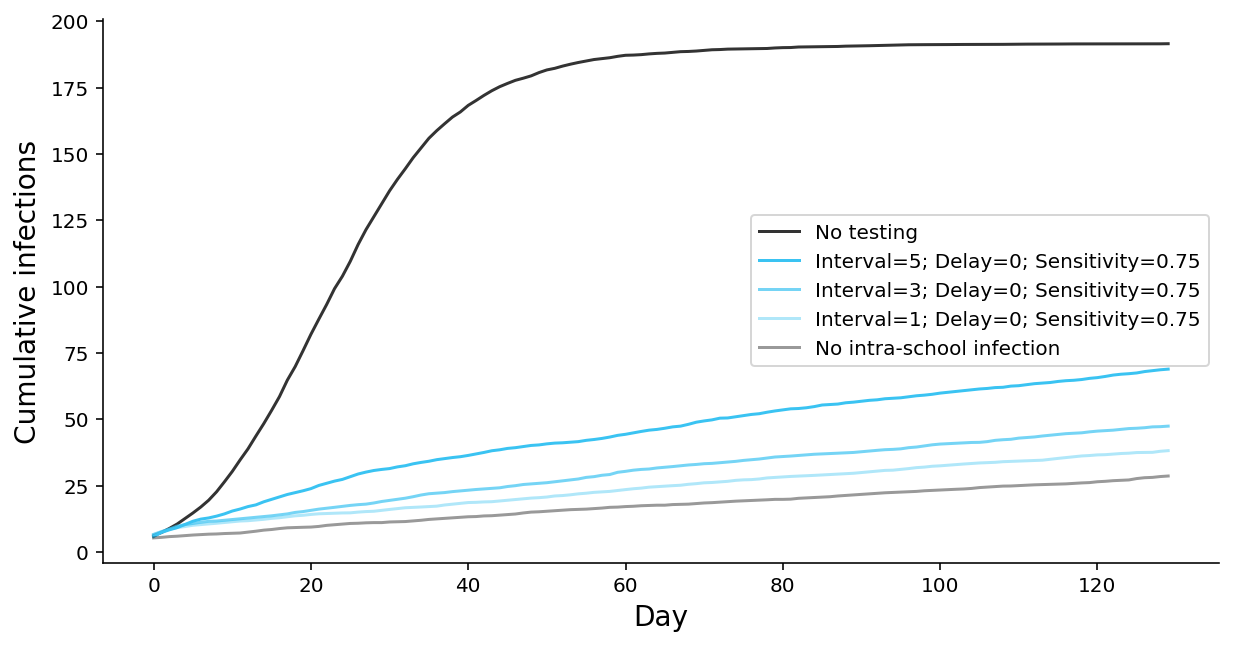

In [55]:
preplot()
plt.plot(results_5_0_75['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_5_0_75)
plt.plot(results_3_0_75['cumulative_infections'], color=blue, alpha=0.7, label=candidate_name_3_0_75)
plt.plot(results_1_0_75['cumulative_infections'], color=blue, alpha=0.4, label=candidate_name_1_0_75)
postplot()

In [56]:
config={
    'testing_interval': 2, 
    'testing_delay': 0,
    'sensitivity': 0.0
}
candidate_name_2_0_00 = get_candidate_name_from_config(config)
results_2_0_00 = run_simulations(config)

config={
    'testing_interval': 2, 
    'testing_delay': 0,
    'sensitivity': 0.3
}
candidate_name_2_0_30 = get_candidate_name_from_config(config)
results_2_0_30 = run_simulations(config)


config={
    'testing_interval': 2, 
    'testing_delay': 0,
    'sensitivity': 0.6
}
candidate_name_2_0_60 = get_candidate_name_from_config(config)
results_2_0_60 = run_simulations(config)


config={
    'testing_interval': 2, 
    'testing_delay': 0,
    'sensitivity': 1.0
}
candidate_name_2_0_100 = get_candidate_name_from_config(config)
results_2_0_100 = run_simulations(config)

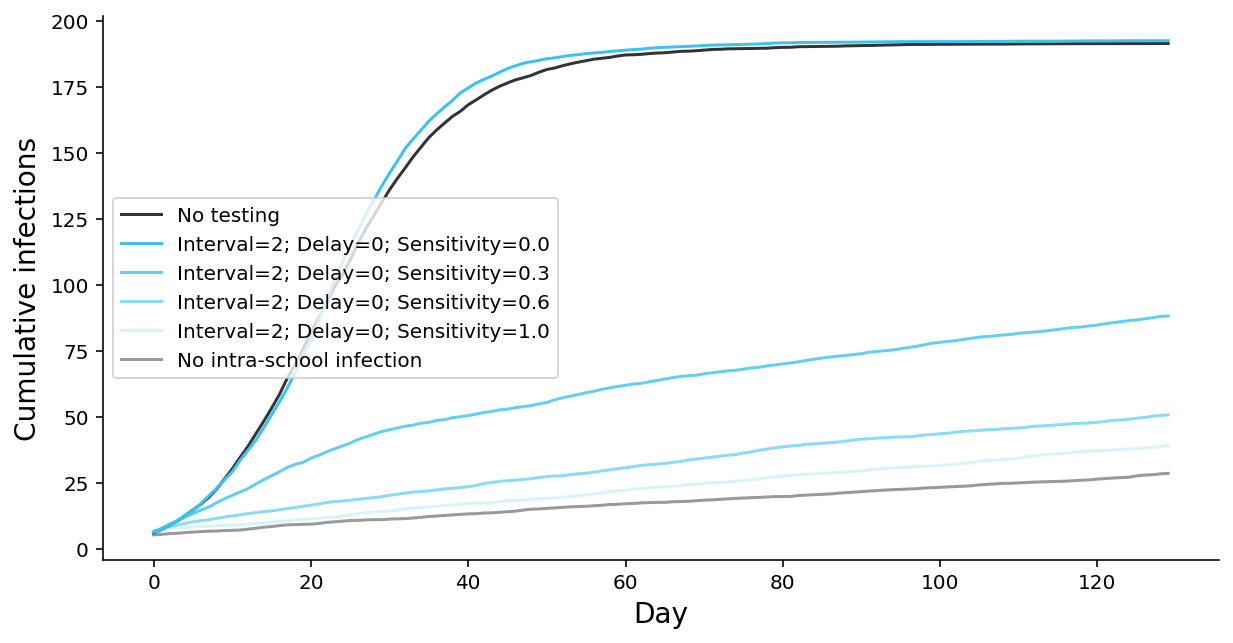

In [57]:
preplot()
plt.plot(results_2_0_00['cumulative_infections'], color=blue, alpha=1.0, label=candidate_name_2_0_00)
plt.plot(results_2_0_30['cumulative_infections'], color=blue, alpha=0.8, label=candidate_name_2_0_30)
plt.plot(results_2_0_60['cumulative_infections'], color=blue, alpha=0.6, label=candidate_name_2_0_60)
plt.plot(results_2_0_100['cumulative_infections'], color=blue, alpha=0.2, label=candidate_name_2_0_100)
postplot()

In [58]:
config={
    'testing_interval': 2, 
    'testing_delay': 5,
    'sensitivity': 0.95,
}
candidate_name_2_5_95 = get_candidate_name_from_config(config)
results_2_5_95 = run_simulations(config)

config={
    'testing_interval': 2, 
    'testing_delay': 3,
    'sensitivity': 0.95,
}
candidate_name_2_3_95 = get_candidate_name_from_config(config)
results_2_3_95 = run_simulations(config)

config={
    'testing_interval': 2, 
    'testing_delay': 1,
    'sensitivity': 0.95,
}
candidate_name_2_1_95 = get_candidate_name_from_config(config)
results_2_1_95 = run_simulations(config)

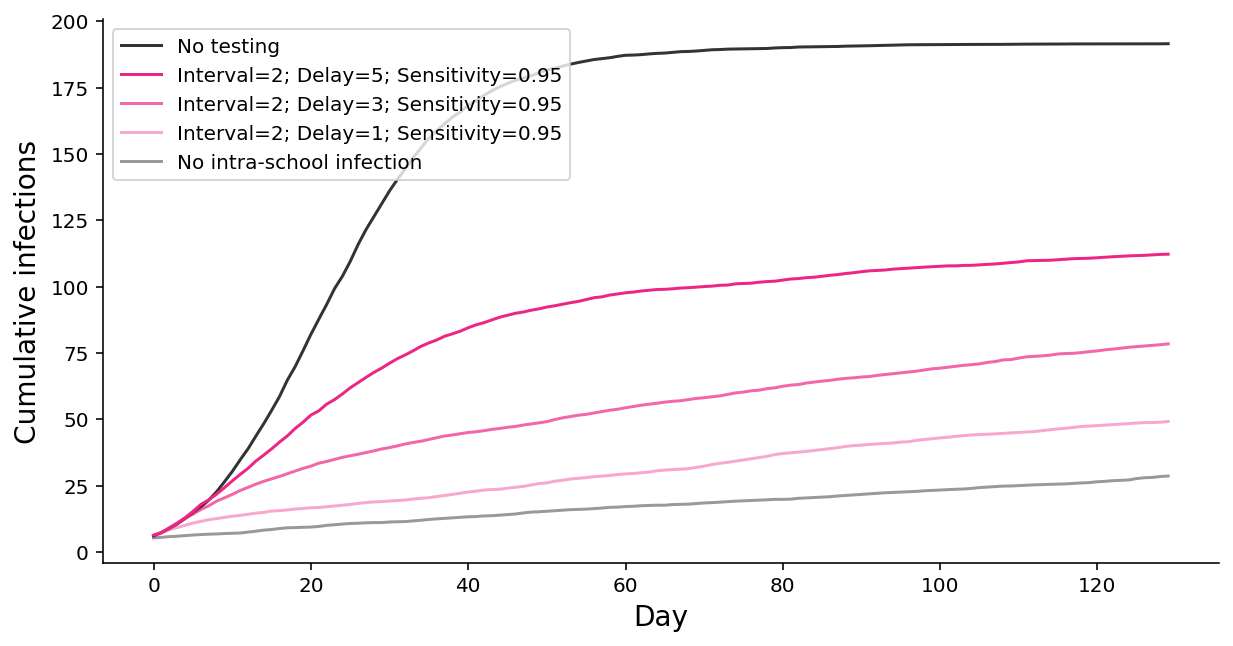

In [59]:
preplot()
plt.plot(results_2_5_95['cumulative_infections'], color=pink, alpha=1.0, label=candidate_name_2_5_95)
plt.plot(results_2_3_95['cumulative_infections'], color=pink, alpha=0.7, label=candidate_name_2_3_95)
plt.plot(results_2_1_95['cumulative_infections'], color=pink, alpha=0.4, label=candidate_name_2_1_95)
postplot()